In [8]:
try:
    import pyserial
except:
    import pip
    pip.main(['install', 'pyserial', 'tweepy', 'textblob', 'nltk', 'tensorflow', 'keras', 'np_utils'])

    


You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [20]:
twitter = pd.read_csv('tweets1.csv',sep=',')

In [21]:
twitter.head()

,Brexit_Tweet,Opinion
0,RT @Holbornlolz: Corbyn Brexit speech summary:...,Positive
1,RT @LeaveEUOfficial: WATCH | Nick Ferrari has ...,Positive
2,@AdamAfriyie @PlanB_earth @friends_earth @NoR3...,Neutral
3,RT @AngryScotland: The most prominent of the p...,Positive
4,RT @OFOCBrexit: Watch what happened on #Victor...,Neutral


In [23]:
list(twitter.columns.values)

['Brexit_Tweet', 'Opinion']

In [24]:
data = twitter[['Brexit_Tweet', 'Opinion']]

In [25]:
data = data[data.Opinion !="Neutral"]
data['Brexit_Tweet'] = data['Brexit_Tweet'].apply(lambda x: x.lower())
data['Brexit_Tweet'] = data['Brexit_Tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
print(data[ data['Opinion'] == 'Positive'].size)
print(data[ data['Opinion'] == 'Negative'].size)

2904
1522


In [28]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['Opinion'].values)
X = tokenizer.texts_to_sequences(data['Opinion'].values)
X = pad_sequences(X)

In [51]:
embed_dim = 100
lstm_out = 150
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1, 100)            200000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 302       
Total params: 350,902
Trainable params: 350,902
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
Y = pd.get_dummies(data['Opinion']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

((1549, 1), (1549, 2))
((664, 1), (664, 2))


In [53]:
X_val = X_train[:500]
Y_val = Y_train[:500]

In [54]:
partial_X_train = X_train[500:]
partial_Y_train = Y_train[500:]

In [55]:
batch_size = 50
history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

Train on 1049 samples, validate on 500 samples
Epoch 1/10
1049/1049 [==============================] - 1s 1ms/step - loss: 0.6239 - acc: 0.7502 - val_loss: 0.5188 - val_acc: 1.0000
Epoch 2/10
1049/1049 [==============================] - 0s 235us/step - loss: 0.3382 - acc: 0.9990 - val_loss: 0.1576 - val_acc: 1.0000
Epoch 3/10
1049/1049 [==============================] - 0s 244us/step - loss: 0.0721 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 4/10
1049/1049 [==============================] - 0s 245us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 5/10
1049/1049 [==============================] - 0s 257us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 6/10
1049/1049 [==============================] - 0s 240us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 7/10
1049/1049 [==============================] - 0s 246us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epo

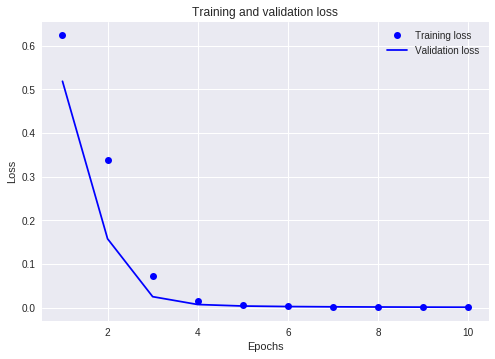

In [56]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

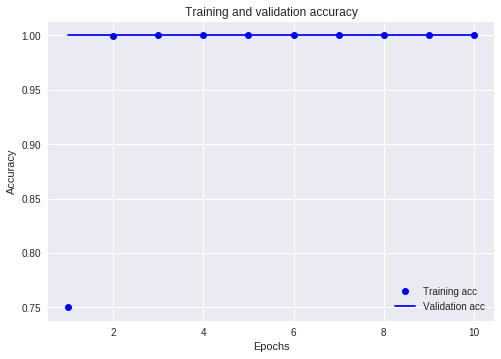

In [57]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [58]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

('pos_acc', 100, '%')
('neg_acc', 100, '%')
